In [41]:
from scipy import stats
import random
from fractions import Fraction
import matplotlib.transforms as transforms
import matplotlib.ticker as ticker

Functions

In [42]:
def safediv(n, d):
    return n/d if d!=0 else np.nan

def find_integer(proportions):
    # Convert proportions to fractions
    fractions = [Fraction(float(p)).limit_denominator() for p in proportions]
    
    # Find the largest denominator
    largest_denominator = max([fraction.denominator for fraction in fractions])
    
    return largest_denominator

def between(array, minv, maxv):
    return [v>=minv and v<maxv for v in array]

def get_overlap(df, close, svars):
    ser = pd.Series([safediv(sum(df[v].between(0,close)), 
                             sum(df[v].between(0,1e10))) 
                     for v in svars])
    ser.index = svars
    counts = pd.Series([len(df)], index=["counts"])
    return ser

def compute_overlap(df, close, svars):
    ser = pd.Series([safediv(sum(df[v].between(0,close)), 
                             sum(df[v].between(0,1e10))) 
                     for v in svars])
    ser.index = svars
    counts = pd.Series([len(df)], index=["counts"])
    ser = ser.append(counts)
    return ser 

def get_perc_from_overlaps(df, svars):
    return pd.Series([stats.percentileofscore(df[v].values[1:], df[v].values[0]) for v in svars], index=svars)

def get_perc_og_conditional(df, close, far, svars, perc_bool):
    
    cond_dist_pairing = {"cpgi":"prdm9", 
                         "prdm9":"cpgi", 
                         "hotspot":"cpgi"}
    
    # No condition on distance to other feature
    results = []
    ecdfs = []
    for v in svars:
        for cond in [False, True]:
            if cond==False:
                sdf = df
            elif cond==True:
                cond_v = cond_dist_pairing[v]
                og_df  = df[df.rep==0]
                keep_ids = og_df[og_df[cond_v]>=far].cross_id.unique()
                sdf = df[df.cross_id.isin(keep_ids)]
            cond_str = "all" if cond==False else "far_from_{}".format(cond_v)
            og_v = []
            shuf_v = []
            for rep,ssdf in sdf.groupby("rep"):
                counts = len(ssdf)
                frac_overlap = safediv(sum(ssdf[v].between(0,close)), 
                                       sum(ssdf[v].between(0,1e10)))
                ecdfs.append([rep, frac_overlap, v, cond_str, counts])
                if rep==0:
                    og_v.append(frac_overlap)
                else:
                    shuf_v.append(frac_overlap)
            
            if len(og_v)!=0:
                perc = stats.percentileofscore(shuf_v, og_v)[0]
            else:
                perc = np.nan
                counts = 0
            results.append([counts, perc, v, cond_str])

    if perc_bool:
        results_df = pd.DataFrame(results)
        results_df.columns = ["counts", "percentile", "feature", "cond"]
        return results_df
    if not perc_bool:
        ecdfs_df = pd.DataFrame(ecdfs)
        ecdfs_df.columns = ["rep", "frac_overlap", "feature", "cond", "counts"]
        return ecdfs_df

def shuf_histplot2(x, **kwargs):
    v = list(x)
    
    # Calculate histogram bins and densities
    hist, bin_edges = np.histogram(v, bins='auto', density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Use sns.lineplot with linestyle '--' to plot dashed lines for histogram bins
    sns.lineplot(x=bin_centers, y=hist, drawstyle='steps', linestyle='--', **kwargs)
    
def shuf_ecdfplot(x, **kwargs):
    v = list(x)
    sns.ecdfplot(v[1:], **kwargs)
    
def shuf_kdeplot(x, **kwargs):
    v = list(x)
    sns.kdeplot(v[1:], **kwargs)
    
def shuf_histplot(x, **kwargs):
    v = list(x)[1:]
    bins = sorted(set(v))
    interval = min([bins[i]-bins[i-1] for i,k in enumerate(bins) if i>0])
    bins = bins + [max(v) + interval]
    bins = [k-(interval/2) for k in bins]
    sns.histplot(v, element="step",stat="probability", 
                 common_norm=False, line_kws={'linestyle': '--'},
                 bins = bins,
                 **kwargs)#, 
    
def og_avline(x, **kwargs):
    v = list(x)
    plt.axvline(x=v[0], **kwargs)
    
def annotate_perc(x, y, **kwargs):
    v = list(x)
    og = v[0]
    shuf = v[1:]
    margin = 1e-2
    perc = stats.percentileofscore(shuf, og, kind="strict") # 
    r = sum([1 for u in v if u>=og])
    n = len(v)
    print("pvalue", r/n, r, n)
    print(np.percentile(shuf, 2.5), np.percentile(shuf, 97.5), og)
    print("{:.3f}".format(og-np.percentile(shuf, 97.5)),
          "{:.3f}".format(og-np.percentile(shuf, 50)),
          "{:.3f}".format(og-np.percentile(shuf, 2.5)))
    
    print("---")
    rnd = random.uniform(0,0.2)
    N = list(y)[0]
    ax = plt.gca()
    trans = transforms.blended_transform_factory(
    ax.transData,
    ax.transAxes  # For x
    )

    # Use the transform in the annotation
    #ax.annotate('Test', xy=(0.5, 2), xycoords=trans, ha='center', va='center')
    plt.annotate("{:.1f}%-tile".format(perc), xy=(og +margin, 0.9), xycoords=trans, **kwargs)#0.78
    plt.annotate("n={}".format(N), xy=(og +margin, 0.835), xycoords=trans, **kwargs)# 0.73
    
def calculate_overlap(df, feat, close):
    ecdfs = []
    for rep,ssdf in df.groupby("rep"):
        counts = len(ssdf)
        frac_overlap = safediv(sum(ssdf[feat].between(0,close)), 
                               sum(ssdf[feat].between(0,1e10)))
        ecdfs.append([rep, frac_overlap, feat, counts])

    res = pd.DataFrame(ecdfs)
    res.columns = ["rep", "frac", "feat", "counts"]
    return res

def condition_far(df, feat, far):
    og = df[df.rep==0]
    shuf = df[df.rep!=0]
    keep = og[og[feat]>=far].cross_id.values
    return df[df.cross_id.isin(keep)]

Read crossovers and distance to features
- Remove those that have a resolution above 10kb

In [68]:
c = pd.read_csv("../results/crossover.closeshuf.tab.gz", sep="\t", header=None)
c.columns = ["scaf", "start", "end", "cross_id", "cpgi", "prdm9", "hotspot","rep", "fam", "allele"]
with open("../misc_files/crossids_nonhot.txt","r") as fh:
    nonhot = [line.strip() for line in fh]
c["width"] = c.end - c.start
c = c[(c.width<5e3)] #& (c.width>100)]

Remove those crossovers that couldn't be shuffled in some of the runs
and print their number 

In [69]:
lec = c.groupby("cross_id").count()
failed = len(c[c.cross_id.isin(list(lec[lec.scaf!=lec.scaf.values[0]].index))])
print("{} crossovers couldn't be shuffled every time".format(failed))
c = c[~c.cross_id.isin(list(lec[lec.scaf!=lec.scaf.values[0]].index))]

0 crossovers couldn't be shuffled every time


Assign scaffolds to chromosome types (macro, micro or unknown)

In [70]:
ctypes = pd.read_csv("../corn_macro_micro_dnazoo.tab",sep="\t").set_index("scaf")["nature"].to_dict()
c["ctype"] = [ctypes[scaf] if scaf in ctypes else "unk" for scaf in c.scaf]

c["parent"] = [f[-1] for f in c.fam]
#c2p = pd.read_csv("../misc_files/crossover2parent.tab",sep="\t",header=None).set_index(0)[1].to_dict()
#c["parent"] = [c2p[cross_id] for cross_id in c.cross_id]

- Annotate the parent, family and allele for each crossover
- Keep only combinations where the crossovers have been combined with PRDM9s in the corresponding family

In [71]:
c["comb"] = c.parent + "_" + c.fam + "_" + c.allele
c = c[(c.fam==c.allele) & (c.ctype!="unk")] # 

Do CpG islands and PRDM9 binding sites overlap very often?

In [72]:
i2p = c.groupby("rep").apply(lambda x: len(x[(x.cpgi==0) & (x.prdm9==0)])/len(x)).reset_index()
i2p.columns = ["rep", "overlap"]

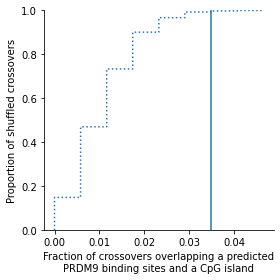

In [73]:
f,ax = plt.subplots(figsize=[4,4])
sns.ecdfplot(data=i2p[i2p.rep!=0], 
             x="overlap",
             linestyle="dotted",
             ax=ax)
ax.axvline(x=i2p[i2p.rep==0].overlap[0])
sns.despine()
ax.set_ylabel("Proportion of shuffled crossovers")
ax.set_xlabel("Fraction of crossovers overlapping a predicted\nPRDM9 binding sites and a CpG island")
plt.tight_layout()
#plt.savefig("pdfs/crossovers_below5kb_overlap_cpgi_prdm9.pdf")

Calculate fraction of overlap with features in original set vs. shuffled

In [74]:
close = 500
far = 10e3
svars = ["cpgi", "prdm9", "hotspot"]
subd = c#[c.ctype=="micro"]
ecdf = get_perc_og_conditional(df=subd, close=close, far=far, svars=svars, perc_bool=False)
perc = get_perc_og_conditional(df=subd, close=close, far=far, svars=svars, perc_bool=True)
ecdf["row"] = ecdf.feature + " | crossovers_" + ecdf.cond 

s = ecdf[((ecdf.feature=="prdm9") & (ecdf.cond=="far_from_cpgi")) & (ecdf.rep!=0)]

When looking at macros, is the CpG islands signal resilient to downsampling?

pvalue 0.00033344448149383126 1 2999
0.08139534883720931 0.1744186046511628 0.27325581395348836
0.099 0.145 0.192
---
pvalue 0.007002334111370457 21 2999
0.04838709677419355 0.1935483870967742 0.22580645161290322
0.032 0.113 0.177
---
pvalue 0.001333777925975325 4 2999
0.06976744186046512 0.16279069767441862 0.20348837209302326
0.041 0.087 0.134
---
pvalue 0.0006668889629876625 2 2999
0.046153846153846156 0.18461538461538463 0.26153846153846155
0.077 0.154 0.215
---
pvalue 0.00033344448149383126 1 2999
0.029069767441860465 0.09883720930232558 0.19186046511627908
0.093 0.128 0.163
---
pvalue 0.18839613204401467 565 2999
0.015384615384615385 0.12307692307692308 0.09230769230769231
-0.031 0.031 0.077
---


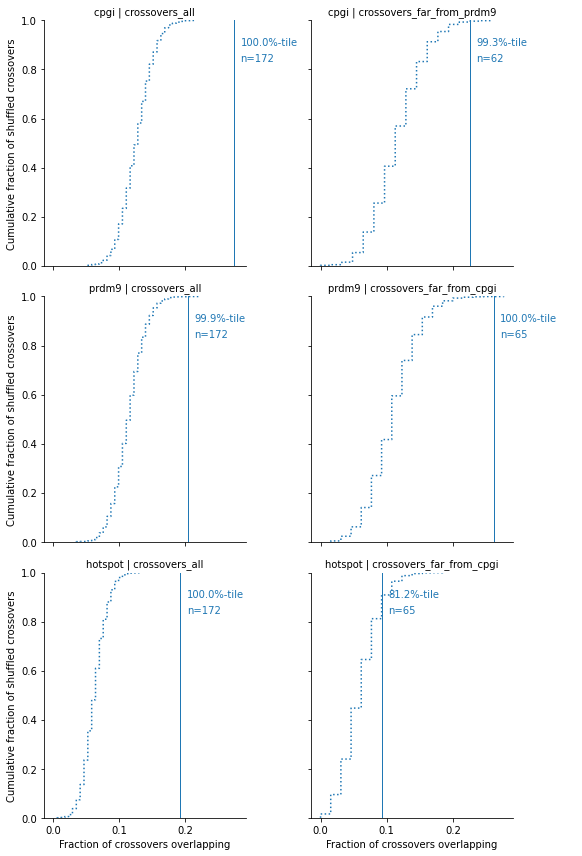

In [75]:
subd = ecdf#[ecdf.row.isin(["cpgi | crossovers_far_from_prdm9","prdm9 | crossovers_far_from_cpgi"])]

g = sns.FacetGrid(data=subd, col="row", height=4,aspect=1, col_wrap=2)
g.map(shuf_ecdfplot, "frac_overlap", linestyle="dotted")
g.map(og_avline, "frac_overlap", linewidth=1)
g.map(annotate_perc, "frac_overlap", "counts")

g.add_legend()
g.set_titles(col_template = '{col_name}')
g.set_axis_labels("Fraction of crossovers overlapping", 
                  "Cumulative fraction of shuffled crossovers")
g.tight_layout()
#g.savefig("pdfs/all_hmm.pdf")

In [76]:
ssubd = subd[(subd.feature=="cpgi") & 
             (subd.cond=="all")]
perc = np.percentile(ssubd[ssubd.rep>0].frac_overlap, 2.5)
obs = list(ssubd.frac_overlap)[0]
print(obs - perc, obs, perc)

0.19186046511627905 0.27325581395348836 0.08139534883720931


pvalue 0.0006668889629876625 2 2999
0.046153846153846156 0.18461538461538463 0.26153846153846155
0.077 0.154 0.215
---
pvalue 0.007002334111370457 21 2999
0.04838709677419355 0.1935483870967742 0.22580645161290322
0.032 0.113 0.177
---


/Users/marc/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:236: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()
/Users/marc/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:236: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


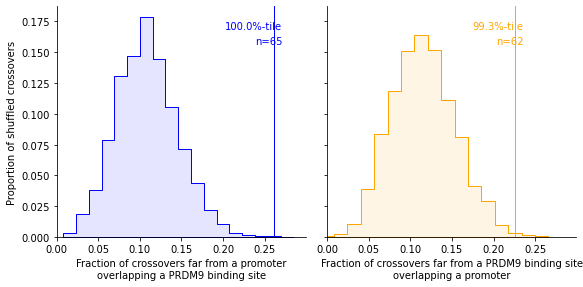

In [77]:
subd = ecdf[ecdf.row.isin(["cpgi | crossovers_far_from_prdm9", 
                           "prdm9 | crossovers_far_from_cpgi"])]

col_order = ["prdm9 | crossovers_far_from_cpgi","cpgi | crossovers_far_from_prdm9" ]
colors = ["blue", "orange"]
palette = {c:colors[i] for i,c in enumerate(col_order)}
g = sns.FacetGrid(data=subd, col="row", height=4.1,aspect=1, 
                  col_order = col_order,
                  palette = palette,
                  hue="row")

g.map(shuf_histplot, "frac_overlap", alpha=0.1)
#g.map(shuf_ecdfplot, "frac_overlap", linestyle="dotted")
#g.map(shuf_kdeplot, "frac_overlap", linestyle="dotted")
g.map(og_avline, "frac_overlap", linewidth=1)
g.map(annotate_perc, "frac_overlap", "counts", ha="right")

g.set_titles(row_template = '{row_name}')
g.set_axis_labels("Fraction of crossovers overlapping", 
                  "Proportion of shuffled crossovers")

for feat_c,ax in g.axes_dict.items():
    feat = feat_c.split()[0]
    if feat=="prdm9":
        ax.set_xlabel("Fraction of crossovers far from a promoter\noverlapping a PRDM9 binding site")
        ax.set_title("")
    if feat=="cpgi":
        ax.set_xlabel("Fraction of crossovers far from a PRDM9 binding site\noverlapping a promoter")
        ax.set_title("")
    
g.set(xlim=(0, None))
plt.tight_layout()
#g.savefig("pdfs/overlap_crossovers_below_5kb_grace_500bp_TSS_pdf_micro.pdf", bbox_inches='tight')
#g.savefig("pdfs/overlap_crossovers_below_5kb_grace_500bp_TSS_pdf_micro.jpg", dpi=400, bbox_inches='tight')

In [78]:
close = 500
far = 10e3
feats = ["prdm9", "cpgi"]
cond = {"prdm9":"cpgi", "cpgi":"prdm9", "hotspot":"cpgi"}

dat = pd.DataFrame()
for feat in feats:
    res_all = calculate_overlap(c, feat, close)
    res_all["cond"] = "all"
    res_all["ctype"] = "all"
    res_con = calculate_overlap(condition_far(c, cond[feat], far), feat, close) 
    res_con["cond"] = "cond"
    res_con["ctype"] = "all"
    dat = pd.concat([dat, res_all, res_con])
    for ctype,sc in c.groupby("ctype"):
        res_all = calculate_overlap(sc, feat, close)
        res_all["cond"] = "all"
        res_all["ctype"] = ctype
        res_con = calculate_overlap(condition_far(sc, cond[feat], far), feat, close) 
        res_con["cond"] = "cond"
        res_con["ctype"] = ctype
        dat = pd.concat([dat, res_all, res_con])

pvalue 0.0006668889629876625 2 2999
0.046153846153846156 0.18461538461538463 0.26153846153846155
0.077 0.154 0.215
---
pvalue 0.007002334111370457 21 2999
0.04838709677419355 0.1935483870967742 0.22580645161290322
0.032 0.113 0.177
---


/Users/marc/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:236: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()
/Users/marc/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:236: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()


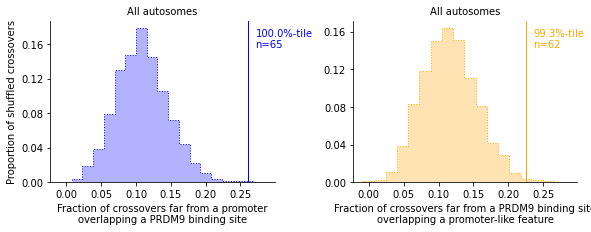

In [79]:
palette = {"cpgi":"orange", "prdm9":"blue"}
g = sns.FacetGrid(data=dat[(dat.cond=="cond") & (dat.ctype=="all")], 
                  col="feat", row="ctype", hue="feat", palette=palette,
                  height=3.33, legend_out=False, sharey=False, aspect=1.25)
g.map(shuf_histplot, "frac", linestyle="dotted", alpha=0.3)
g.map(og_avline, "frac", linewidth=1)
g.map(annotate_perc, "frac", "counts")

g.set_titles(row_template = '{row_name}')
g.set_axis_labels("Fraction of crossovers overlapping", 
                  "Proportion of shuffled crossovers")

labels = {"all":"All autosomes", "macro":"Macrochromosomes", "micro":"Microchromosomes"}
for (ctype, feat),ax in g.axes_dict.items():
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    if feat=="prdm9":
        #ax.set_xlabel("Overlap fraction with PRDM9 binding sites")
        ax.set_xlabel("Fraction of crossovers far from a promoter\noverlapping a PRDM9 binding site")
        ax.set_title(labels[ctype], fontsize=10)
    if feat=="cpgi":
        ax.set_xlabel("Fraction of crossovers far from a PRDM9 binding site\noverlapping a promoter-like feature")
        ax.set_title(labels[ctype], fontsize=10)
plt.tight_layout()
#plt.savefig("pdfs/Figure4_all.pdf")
#plt.savefig("pdfs/Figure4_all.jpg", dpi=400)

In [97]:
close = 500
far = 10e3
dat_parent = pd.DataFrame()

for parent,df in c.groupby("parent"):
    for feat in feats:
        res = calculate_overlap(condition_far(df, cond[feat], far), feat, close)
        res["parent"] = parent
        dat_parent = pd.concat([dat_parent, res])

Sex usage of features

In [98]:
dat_parent[dat_parent.rep==0]

,rep,frac,feat,counts,parent
0,0,0.210526,prdm9,38,M
0,0,0.166667,cpgi,36,M
0,0,0.333333,prdm9,27,P
0,0,0.307692,cpgi,26,P


In [99]:
dat_parent[dat_parent.rep==0].frac * dat_parent[dat_parent.rep==0].counts

0    8.0
0    6.0
0    9.0
0    8.0
dtype: float64

In [102]:
from scipy.stats import chi2_contingency
from scipy.stats import fisher_exact

# PRDM9
#observed = [[20, 15], [102-20, 70-15]]
observed = [[8, 9], [38-8, 27-9]]

# Promoters
#observed = [[30, 17], [102-30, 70-17]]
#observed = [[6, 8], [36-6, 26-8]]

# Perform the Chi-squared test
#chi2, p, dof, expected = chi2_contingency(observed)
ratio, p = fisher_exact(observed)
print(p)

0.39081481150479724


pvalue 0.027009003001000332 81 2999
0.02631578947368421 0.21052631578947367 0.21052631578947367
0.000 0.105 0.184
---
pvalue 0.14938312770923642 448 2999
0.027777777777777776 0.19444444444444445 0.16666666666666666
-0.028 0.056 0.139
---
pvalue 0.003334444814938313 10 2999
0.0 0.25925925925925924 0.3333333333333333
0.074 0.222 0.333
---
pvalue 0.012337445815271757 37 2999
0.038461538461538464 0.2692307692307692 0.3076923076923077
0.038 0.192 0.269
---


/Users/marc/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:236: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()
/Users/marc/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:236: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()
/Users/marc/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:236: UserWarning: Legend does not support handles for Annotation instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  handles, labels = ax.get_legend_handles_labels()
/Users/marc/opt/anaconda3/lib/python3.8/site-packages/seab

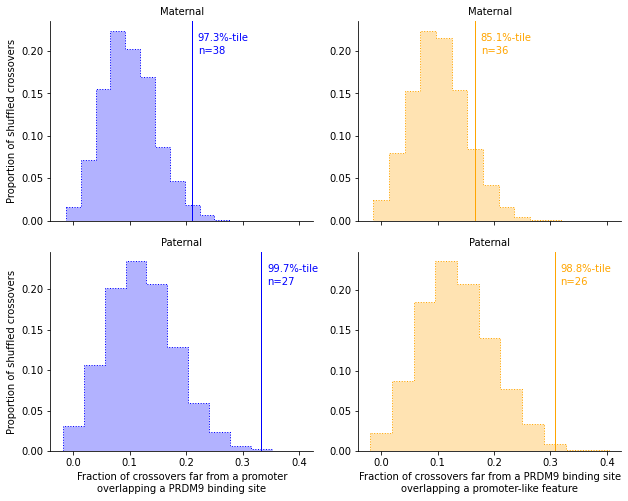

In [106]:
palette = {"cpgi":"orange", "prdm9":"blue"}
g = sns.FacetGrid(data=dat_parent, 
                  col="feat", row="parent", hue="feat", palette=palette,
                  height=3.53, legend_out=False, sharey=False, aspect=1.25)
g.map(shuf_histplot, "frac", linestyle="dotted", alpha=0.3)
g.map(og_avline, "frac", linewidth=1)
g.map(annotate_perc, "frac", "counts")

g.set_titles(row_template = '{row_name}')
g.set_axis_labels("Fraction of crossovers overlapping", 
                  "Proportion of shuffled crossovers")

labels = {"M":"Maternal", "P":"Paternal"}
for (ctype, feat),ax in g.axes_dict.items():
    ax.yaxis.set_major_locator(ticker.MaxNLocator(nbins=5))
    if feat=="prdm9":
        #ax.set_xlabel("Overlap fraction with PRDM9 binding sites")
        ax.set_xlabel("Fraction of crossovers far from a promoter\noverlapping a PRDM9 binding site")
        ax.set_title(labels[ctype], fontsize=10)
    if feat=="cpgi":
        ax.set_xlabel("Fraction of crossovers far from a PRDM9 binding site\noverlapping a promoter-like feature")
        ax.set_title(labels[ctype], fontsize=10)
plt.tight_layout()

plt.tight_layout()
plt.savefig("pdfs/Figure_sexes.pdf")
plt.savefig("pdfs/Figure_sexes.jpg", dpi=400)

Sex ratio

In [23]:
import statsmodels.stats.proportion as ssp
from scipy.stats import binom_test

In [24]:
ssp.proportion_confint(177, 324)

(0.4920867370469248, 0.6005058555456678)

In [25]:
binom_test(x=177,n=324, p=0.5)

0.1070113856928635

In [26]:
#g = sns.FacetGrid(data=dat_parent, col="feat", hue="parent", height=12, legend_out=False)
#g.map(shuf_histplot, "frac", linestyle="dotted")
#g.map(og_avline, "frac", linewidth=1)
#g.map(annotate_perc, "frac", "counts")

Hotspot

In [142]:
close = 500
far = 10e3
feats = ["hotspot"]
conds = ["prdm9", "cpgi"]

dat = pd.DataFrame()
for feat in feats:
    res_all = calculate_overlap(c, feat, close)
    res_all["cond"] = "all"
    dat = pd.concat([dat, res_all])
    for cond in conds:
        res_con = calculate_overlap(condition_far(c, cond, far), feat, close) 
        res_con["cond"] = cond
        dat = pd.concat([dat, res_con])

In [143]:
def annotate_perc(x, y, **kwargs):
    v = list(x)
    og = v[0]
    shuf = v[1:]
    margin = 2e-3
    perc = stats.percentileofscore(shuf, og)
    r = sum([1 for u in v if u>=og])
    n = len(v)
    print("pvalue", r/n, r, n)
    rnd = random.uniform(0,0.2)
    N = list(y)[0]
    ax = plt.gca()
    trans = transforms.blended_transform_factory(
    ax.transData,
    ax.transAxes  # For x
    )

    # Use the transform in the annotation
    #ax.annotate('Test', xy=(0.5, 2), xycoords=trans, ha='center', va='center')
    plt.annotate("{:.1f}%-tile".format(perc), xy=(og + margin, 0.9), xycoords=trans, **kwargs)#0.78
    plt.annotate("n={}".format(N), xy=(og + margin, 0.85), xycoords=trans, **kwargs)# 0.73

pvalue 0.00033344448149383126 1 2999
pvalue 0.0010003334444814939 3 2999
pvalue 0.2914304768256085 874 2999
all
prdm9
cpgi


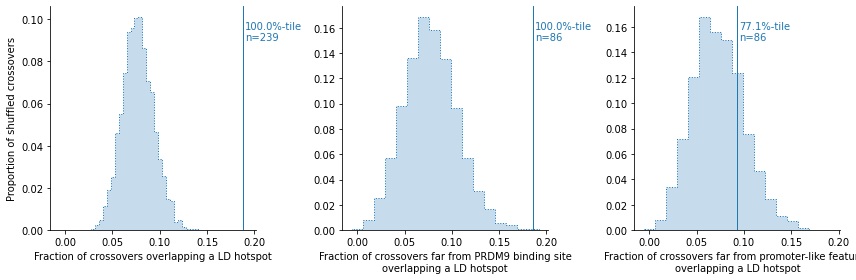

In [144]:
g = sns.FacetGrid(data=dat, col="cond", height=4, legend_out=False, sharey=False)
g.map(shuf_histplot, "frac", linestyle="dotted", alpha=0.25)
g.map(og_avline, "frac", linewidth=1)
g.map(annotate_perc, "frac", "counts")
g.set_axis_labels("", "Proportion of shuffled crossovers")
for feat_c,ax in g.axes_dict.items():
    feat = feat_c.split()[0]
    print(feat)
    if feat=="all":
        ax.set_xlabel("Fraction of crossovers overlapping a LD hotspot")
        ax.set_title("")
    if feat=="prdm9":
        ax.set_xlabel("Fraction of crossovers far from PRDM9 binding site\noverlapping a LD hotspot")
        ax.set_title("")
    if feat=="cpgi":
        ax.set_xlabel("Fraction of crossovers far from promoter-like features\noverlapping a LD hotspot")
        ax.set_title("")

g.tight_layout()
g.savefig("pdfs/overlap_crossovers_LD_hotspots.pdf", bbox_inches='tight')
g.savefig("pdfs/overlap_crossovers_LD_hotspots.jpg", dpi=400, bbox_inches='tight')

In [ ]:
subd = c[c.ctype=="macro"]

close = 500
far = 10e3
reps = 500
features = ["prdm9", "cpgi"]
res_l = []

for i,feat in enumerate(features[:1]):
    ofeat = features[::-1][i]
    seld = condition_far(subd, feat, far)
    ids = seld.cross_id.unique()
    for r in range(reps):
        dids = np.random.choice(ids, size=19, replace=False)
        dseld = seld[seld.cross_id.isin(dids)]
        frac = calculate_overlap(dseld, ofeat, close)
        perc = stats.percentileofscore(frac.frac.values[1:], frac.frac.values[0], kind="strict")
        res_l.append([ofeat, r, perc])
        
sh = pd.DataFrame(res_l)
sh.columns = ["feat", "rep", "perc"]

f,ax = plt.subplots(figsize=[5,6])
sns.histplot(data=sh, x="perc", binwidth=2.5, ax=ax, stat="probability")
ax.axvline(x=54.2, color="gray", linestyle="dotted")
ax.set_xlabel("Percentile")
ax.set_title("500 random downsamplings of 19 crossovers\nfar from PRDM9 binding sites in macrochromosomes", fontsize=10)
sns.despine()
plt.tight_layout()
plt.savefig("pdfs/random_subsamplings_macro.jpg", dpi=400)